In [76]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import imodels
import eval_feat_select
from collections import defaultdict
from typing import List
import dvu
import imodelsx
import imodelsx.viz
import imodelsx.llm

import openai
openai.api_key_path = '/home/chansingh/.OPENAI_KEY'


dvu.set_style()
df = pd.read_pickle("../data/data_clean.pkl")
n = df.shape[0]

def raw_to_abbrev(feat_name: str):
    return feat_name.split("_")[0]


def abbrevs_to_idxs_raw(feat_names_abbrev, feat_names_raw: pd.Series):
    return feat_names_raw.apply(lambda x: raw_to_abbrev(x) in feat_names_abbrev).values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
X, y, feat_names_raw = imodels.get_clean_dataset('iai_pecarn_prop', data_source='imodels')
feat_names_raw = pd.Series(feat_names_raw)
df = pd.DataFrame(X, columns=feat_names_raw)

# remove redundant features
idxs = (feat_names_raw.str.endswith('_no') | feat_names_raw.str.endswith('_unknown'))

# remove compound features
idxs |= (feat_names_raw.str.contains('_or_'))

# remove ambiguous features
idxs |= (feat_names_raw.str.lower().str.startswith('other'))

# remove specific features
idxs |= feat_names_raw.isin(['Age<2_yes'])

# apply
X = X[:, ~idxs]
feat_names_raw = feat_names_raw[~idxs]
feat_names_abbrev_unique = set(feat_names_raw.apply(raw_to_abbrev))
print(f'Unique features: {len(feat_names_abbrev_unique)}')

Unique features: 21


In [78]:
rng = np.random.default_rng(42)
# feat_names_select = rng.choice(list(feat_names_abbrev_unique), size=5, replace=False)
feat_names_select = ['AbdTrauma']
idxs_raw = abbrevs_to_idxs_raw(feat_names_select, feat_names_raw)
eval_feat_select.evaluate_features(X[:, idxs_raw], y, seed=42, test_size=0.3)

{'roc_auc': 0.697032497600711,
 'accuracy': 0.016854845271538486,
 'f1': 0.03315085925482211,
 'precision': 0.016854845271538486,
 'recall': 1.0}

In [79]:
def get_feat_names_ordered(
    feat_names_abbrev_unique: List[str], strategy="random", seed: int = 42
):
    rng = np.random.default_rng(seed)
    if strategy == "random":
        feat_names_ordered = rng.choice(
            list(feat_names_abbrev_unique),
            size=len(feat_names_abbrev_unique),
            replace=False,
        )
        return feat_names_ordered
    elif strategy == "pecarn":
        PECARN_FEAT_NAMES_ORDERED = [
            "AbdTrauma",
            "SeatBeltSign",
            "GCSScore",
            "AbdTenderDegree",
            "ThoracicTrauma",
            "AbdomenPain",
            "DecrBreathSound",
            "VomitWretch",
        ]
        remaining_feats = [k for k in feat_names_abbrev_unique if k not in PECARN_FEAT_NAMES_ORDERED]
        return list(PECARN_FEAT_NAMES_ORDERED) + rng.choice(
            remaining_feats, size=len(remaining_feats), replace=False
        ).tolist()



strategies = ["random", "pecarn"]
mets_list_strategies = defaultdict(list)
for strategy in strategies:
    for seed in range(3):
        mets_seed = defaultdict(list)
        feat_names_ordered = get_feat_names_ordered(
            feat_names_abbrev_unique, strategy=strategy, seed=seed
        )
        for i in tqdm(range(len(feat_names_ordered))):
            feat_names_select = feat_names_ordered[: i + 1]
            idxs_raw = abbrevs_to_idxs_raw(feat_names_select, feat_names_raw)
            met_scores = eval_feat_select.evaluate_features(
                X[:, idxs_raw], y, seed=42 + seed, test_size=0.3
            )
            for k in met_scores:
                mets_seed[k].append(met_scores[k])
        mets_list_strategies[strategy].append(pd.DataFrame(mets_seed))

# convert mets_list_strategies to mets_avg
mets_avg = defaultdict(list)
for strategy in strategies:
    m = mets_list_strategies[strategy]
    cols = m[0].columns
    mets_mean = pd.DataFrame(
        data=np.mean(
            [m[i].values for i in range(len(mets_list_strategies))], axis=0
        ),
        columns=cols,
    )
    mets_sem = pd.DataFrame(
        data=np.std([m[i].values for i in range(len(mets_list_strategies))], axis=0)
        / np.sqrt(len(m)),
        columns=[k + "_sem" for k in cols],
    )
    mets_avg[strategy] = pd.concat([mets_mean, mets_sem], axis=1)

100%|██████████| 21/21 [00:07<00:00,  2.64it/s]


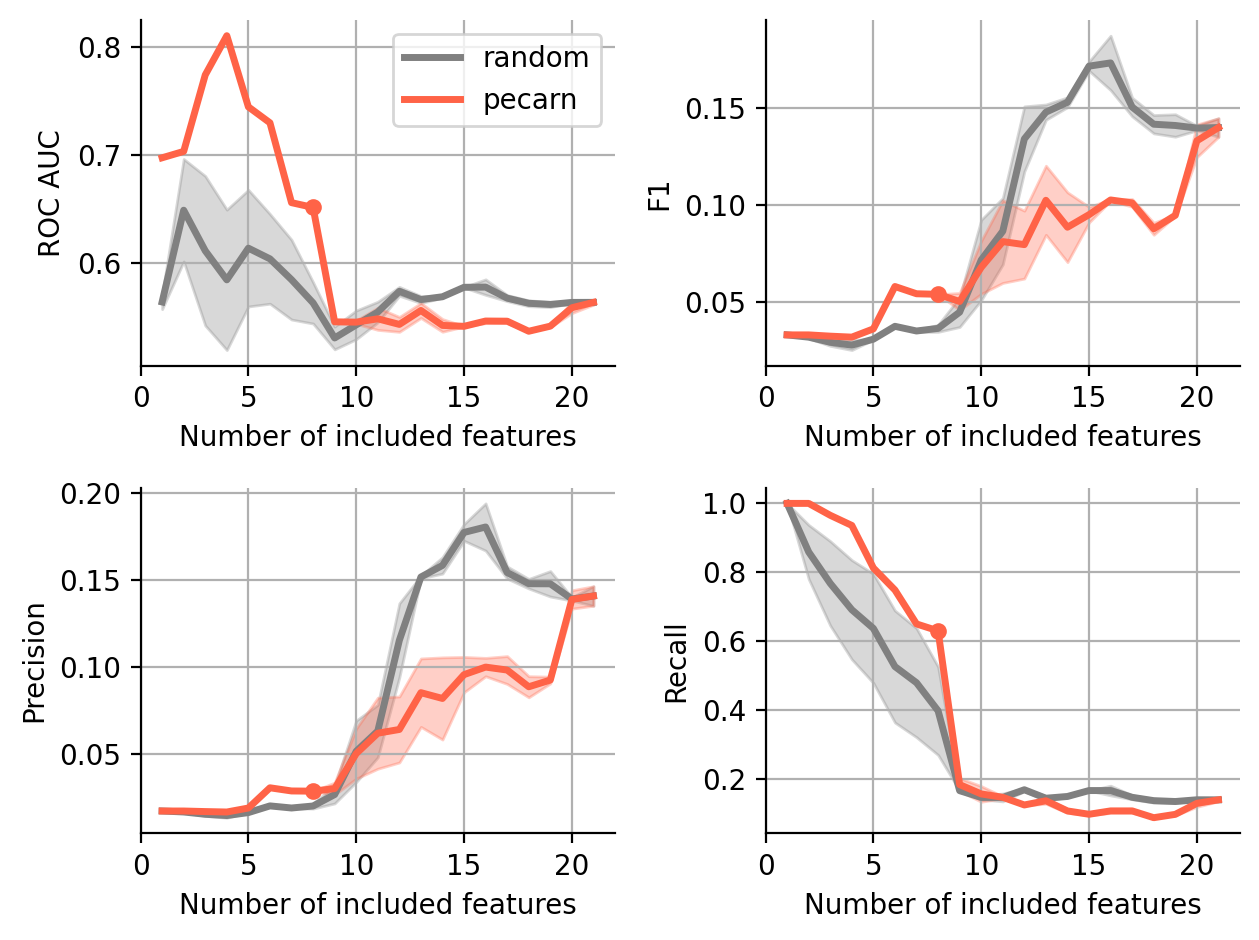

In [80]:
plt.figure(dpi=200) #, figsize=(3, 2))
R, C = 2, 2
COLORS = {
    'random': 'gray',
    'pecarn': 'tomato',
}

mets = ["roc_auc", "f1", "precision", "recall"]
for i, met in enumerate(mets):
    plt.subplot(R, C, i + 1)
    for strategy in strategies:
        m = mets_avg[strategy]
        x = np.arange(len(m)) + 1
        color = COLORS.get(strategy, 'k')
        plt.plot(x, m[met], lw=2.5, label=strategy, color=color)
        plt.fill_between(
            x,
            m[met] - m[met + '_sem'],
            m[met] + m[met + '_sem'],
            alpha=0.3,
            color=color,
        )
    
    # mark pecarn point
    if strategy == 'pecarn':
        n = 8
        plt.plot(8, m[met][n -1], 'o', color=color, ms=5)
    

    # plt.errorbar(x=np.arange(len(mets_avg)) + 1, y=mets_avg['f1'], yerr=mets_sem['f1'], lw=3, label='F1')
    plt.xlabel("Number of included features")
    plt.ylabel(imodelsx.viz.METRICS_RENAME_DICT.get(met, met))
    if i == 0:
        plt.legend()
    plt.grid(zorder=-100)
plt.tight_layout()
plt.show()

In [72]:
llm = imodelsx.llm.get_llm(checkpoint='gpt-3.5-turbo', repeat_delay=1)

In [81]:
RENAMES = {
    'AbdDistention': 'Abdominal distention',
    'AbdTenderDegree': 'Degree of abdominal tenderness',
    'AbdTrauma': 'Abdominal wall trauma',
    'AbdomenPain': 'Abdominal pain',
    'Age': 'Age',
    'CostalTender': 'Costal tenderness',
    'DecrBreathSound': 'Decreased breath sounds',
    'DistractingPain': 'Distracting pain',
    'GCSScore': 'GCS score',
    'Hypotension': 'Hypotension',
    'InitHeartRate': 'Heart rate',
    'InitSysBPRange': 'Systolic blood pressure',
    'LtCostalTender': 'Left costal tenderness',
    'MOI': 'Mechanism of injury',
    'Race': 'Race',
    'RtCostalTender': 'Right costal tenderness',
    'SeatBeltSign': 'Seatbelt sign',
    'Sex': 'Sex',
    'ThoracicTender': 'Thoracic tenderness',
    'ThoracicTrauma': 'Thoracic trauma',
    'VomitWretch': 'Vomiting'
}

In [86]:
feat_names_clean_unique = list(map(RENAMES.get, feat_names_abbrev_unique))
back = '\n'
prompt = f"""Which of the following features is most important for predicting intra-abominal injury requiring intervention?
- {'n- '.join(feat_names_clean_unique)}

Answer:"""

SyntaxError: f-string expression part cannot include a backslash (4270428274.py, line 5)

In [73]:
llm(
    
)

not cached
Rate limit reached for default-gpt-3.5-turbo in organization org-rocrupyvzgcl4yf25rqq6d1v on tokens per min. Limit: 90000 / min. Current: 89847 / min. Contact us through our help center at help.openai.com if you continue to have issues.
not cached


'fruit.'